In [1]:
# Imports
import pathlib
import os
import numpy as np
import seaborn as sns
import plotly.express as px
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import preprocessing, mixed_precision, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    LSTM,
    BatchNormalization,
    Dropout,
    Conv2D,
    MaxPool2D,
    Flatten,
)
from keras.applications.mobilenet_v3 import (
    MobileNetV3Large,
    decode_predictions,
)
from sklearn import metrics, ensemble
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.config import experimental
import cv2

In [2]:
# Using either TPU or GPU to speed up model fitting
# Use mixed precision policy if TPU/GPUs are detected for additional performance boost
# see https://www.tensorflow.org/guide/mixed_precision
if experimental.list_physical_devices("TPU"):  # Googles Tensor Processing Units
    print("Available TPUs: ", len(experimental.list_physical_devices("TPU")))
    mixed_precision.set_global_policy(mixed_precision.Policy("mixed_bfloat16"))
elif experimental.list_physical_devices("GPU"):  # NVidia GPU
    print("Available GPUs: ", len(experimental.list_physical_devices("GPU")))
    print("Selecting the first GPU...")
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # use the first GPU
    mixed_precision.set_global_policy(mixed_precision.Policy("mixed_float16"))
else:
    print("No TPUs or GPUs detected.")
# Note: if mixed precision float16 is used, your output layer should be transferred to
# float32 because float16 are not always numerically stable.

Available GPUs:  1
Selecting the first GPU...
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080 Ti, compute capability 8.6


In [3]:
def load_images(
    base_path="images",
    image_formats=(".jpg", ".png"),
    grayscale=False,
    image_target_size=(224, 224),
):
    """Loads all the photos we've taken for our database"""
    # Set the root directory for the images
    root_dir = pathlib.Path(base_path)
    images, labels = [], []
    # Iterate through all subdirectories within the root directory
    for subdir in root_dir.iterdir():
        if not subdir.is_dir():
            continue
        # If directory, iterate through all the files in the subdirectory
        for file in subdir.iterdir():
            if file.suffix in image_formats:
                # Load the image, convert to grayscale (optional) and append to image list
                image = preprocessing.image.load_img(path=str(file), target_size=image_target_size)
                if grayscale:
                    image = preprocessing.image.load_img(
                        path=str(file), target_size=image_target_size
                    ).convert("L")
                # Keras works with Pillow natively but OpenCV would work, too:
                # image = cv2.imread(filename=str(file))
                # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                images.append(np.array(image))
                # Get the label for the image and append to labels list
                label = subdir.name
                labels.append(label)
    return np.array(images), np.array(labels), np.unique(labels)

Outline for milestone project
1. Obtain pictures (already done)
We use a premade script that makes pictures with your webcam
See here for the code:
2. Load in our data using openCV and build our dataset
3. Build four models, a baseline model, one new ANN, one CNN and one CNN that builds upon a pre-trained model
4. Redraw the result of the best model back into a frame to get live feedback of which object is detected

### Let's start with some preprocessing:

In [4]:
X_images, y_labels, class_labels = load_images()

# Dataset built, now withhold some dataset for later evaluation while keeping class frequencies similar
X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(
    X_images, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)
# Rescale pixel intensities from a 0-255 to a 0-1 range (i.e., MinMaxScaling)
X_train_og = X_train_og.astype("float32") / 255
X_test_og = X_test_og.astype("float32") / 255

### Model 1: Baseline model: RandomForestClassifier

In [5]:
# For RandomForestClassifier, flatten the array
X_train = X_train_og.reshape((np.shape(X_train_og)[0], -1))
X_test = X_test_og.reshape((np.shape(X_test_og)[0], -1))
y_train = np.copy(y_train_og)
y_test = np.copy(y_test_og)

#### Create and fit model

In [6]:
# Create a classifier: a RandomForestClassifier
base_model = ensemble.RandomForestClassifier(verbose=True)
# Fit
base_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   31.5s finished


RandomForestClassifier(verbose=True)

In [7]:
# Predict the value of the digit on the test subset
predictions = base_model.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [8]:
# Evaluate the model
print(
    f"Classification report for classifier {base_model}:\n"
    f"{metrics.classification_report(y_test, predictions)}\n"
)

Classification report for classifier RandomForestClassifier(verbose=True):
              precision    recall  f1-score   support

       empty       0.99      1.00      0.99        76
       faces       1.00      1.00      1.00        95
        hand       1.00      1.00      1.00       161
         hat       0.99      0.99      0.99       192
         pen       1.00      0.99      1.00       124
  tennisball       1.00      1.00      1.00       117

    accuracy                           1.00       765
   macro avg       1.00      1.00      1.00       765
weighted avg       1.00      1.00      1.00       765




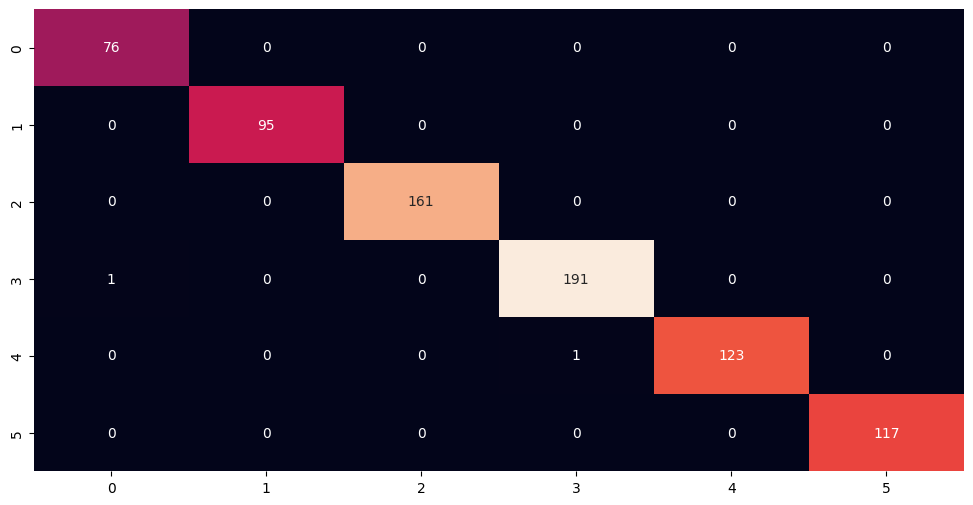

In [9]:
# Plot the confusion matrix of our predictions
_fig, ax5 = plt.subplots(figsize=(12, 6))
sns.heatmap(metrics.confusion_matrix(y_test, predictions), cbar=False, annot=True, fmt="", ax=ax5)
plt.show()

### Model 2: Artificial/Traditional Neural network

In [10]:
# Make sure to always clear session at the beginning to not just update previous model instances
# Note that this is mostly important for Jupyter Notebooks but good practice either way
K.clear_session()
# For ANN, flatten the array. Note that this will flatten the color channel along the blue channel (?)
X_train = X_train_og.reshape((np.shape(X_train_og)[0], -1))
X_test = X_test_og.reshape((np.shape(X_test_og)[0], -1))
# One-hot encode the target classes / labels
# Needed so that the dimensions match the Dense output layer (at least with softmax activation function)
y_train = LabelBinarizer().fit_transform(y_train_og)
y_test = LabelBinarizer().fit_transform(y_test_og)

#### Define our model  
We know that the input are 224 x 224 x 3 images. For ANN, we have flatten the ndarray
The output layer must have as many nodes as there image categories.
Relu is a popular activation function for hidden layers
Softmax is a popular activation function for the last, or output, layer

#### Pipeline the model  
From Keras model training API (https://keras.io/api/models/model_training_apis/)  
- Dense: Regular densely-connected neural network layer  
units: neurons/nodes for that layer  
activation: activation function for the nodes  
input_shape: dimensional shape of the input, only needs to be defined for the first layer  
name: some label you can give that layer  
Note that we do not need to add a bias for each layer as they are automatically added in Keras
for Dense layers
- BatchNormalization: Layer that normalizes the input
- Dropout: Randomly sets input units to 0 with rate frequency during training. Helps to prevent overfitting.

In [11]:
model1 = Sequential(
    name="ANN_model",
    layers=[
        Dense(
            units=200,
            activation="relu",
            input_shape=((np.shape(X_train)[1],)),
            name="HiddenLayer1",
        ),
        BatchNormalization(),
        Dropout(rate=0.5),
        Dense(units=50, activation="relu", name="HiddenLayer2"),
        BatchNormalization(),
        Dropout(rate=0.5),
        Dense(units=np.shape(y_train)[1], activation="softmax", name="OutputLayer"),
    ],
)
model1.summary()

Model: "ANN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HiddenLayer1 (Dense)        (None, 200)               30105800  
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 HiddenLayer2 (Dense)        (None, 50)                10050     
                                                                 
 batch_normalization_1 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 50)                0 

#### Compile the model
loss: loss function to return error estimation  
optimizer: algorithm for loss minimization  
metrics: model performance evaluation metric  


In [12]:
model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#### Fit the model
Before fitting, let's define an early stopping rule on loss of the validation set to prevent overfitting
Fitting parameters:  
batch_size: number of samples per gradient update  
epochs: number of iterations over the entire data (X and y) to train the model  
validation_data: data on which to evaluate the loss and any model metrics at the end of each epoch (no training on this data!)  

In [13]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)


In [14]:
model1_history = model1.fit(
    x=X_train,
    y=y_train,
    batch_size=250,
    epochs=35,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
)

Epoch 1/35
13/13 [==============================] - 2s 69ms/step - loss: 1.5161 - accuracy: 0.5231 - val_loss: 18.6052 - val_accuracy: 0.2510
Epoch 2/35
13/13 [==============================] - 1s 44ms/step - loss: 1.1152 - accuracy: 0.6497 - val_loss: 14.4716 - val_accuracy: 0.2196
Epoch 3/35
13/13 [==============================] - 1s 46ms/step - loss: 0.9277 - accuracy: 0.6955 - val_loss: 8.6850 - val_accuracy: 0.2719
Epoch 4/35
13/13 [==============================] - 1s 44ms/step - loss: 0.8400 - accuracy: 0.7197 - val_loss: 6.1559 - val_accuracy: 0.2967
Epoch 5/35
13/13 [==============================] - 1s 47ms/step - loss: 0.7693 - accuracy: 0.7586 - val_loss: 3.7620 - val_accuracy: 0.4235
Epoch 6/35
13/13 [==============================] - 1s 47ms/step - loss: 0.6873 - accuracy: 0.7740 - val_loss: 3.2184 - val_accuracy: 0.4366
Epoch 7/35
13/13 [==============================] - 1s 44ms/step - loss: 0.5997 - accuracy: 0.8008 - val_loss: 2.3195 - val_accuracy: 0.5451
Epoch 8/35


#### Evaluate the model
Plot the training history


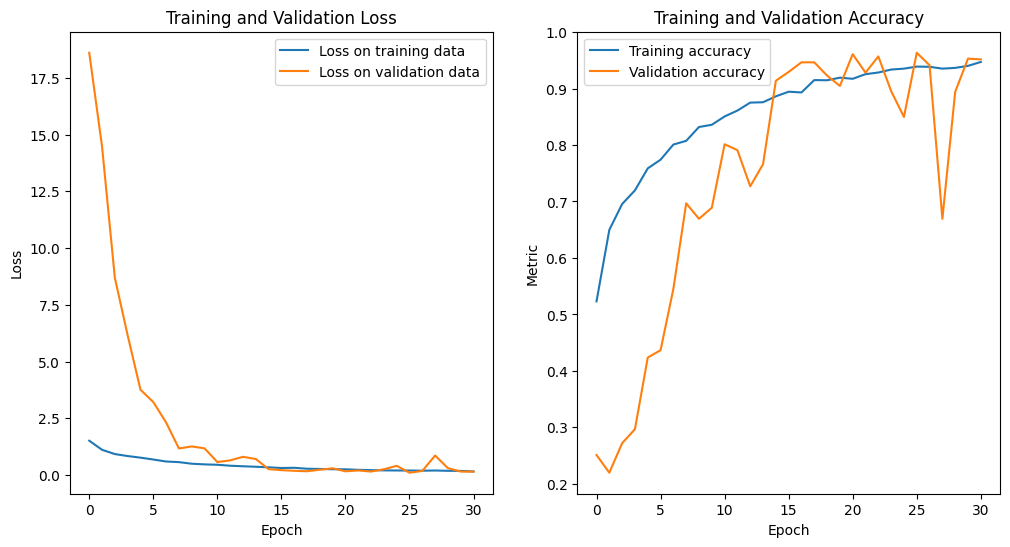

In [15]:
_fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), ncols=2)
ax1.plot(model1_history.history["loss"], label="Loss on training data")
ax1.plot(model1_history.history["val_loss"], label="Loss on validation data")
ax2.plot(model1_history.history["accuracy"], label="Training accuracy")
ax2.plot(model1_history.history["val_accuracy"], label="Validation accuracy")
ax1.set_title("Training and Validation Loss")
ax2.set_title("Training and Validation Accuracy")
ax1.set_xlabel("Epoch")
ax2.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax2.set_ylabel("Metric")
ax1.legend()
ax2.legend()

In [16]:
# Return final model performance scores on training and test data
train_loss, train_acc = model1.evaluate(X_train, y_train)
test_loss, test_acc = model1.evaluate(X_test, y_test)
print("Train accuracy:", round(train_acc, 5))
print(
    "Train loss:",
    round(
        train_loss,
    ),
)
print("Test accuracy:", round(test_acc, 5))
print("Test loss:", round(test_loss, 3))


24/24 [==============================] - 0s 4ms/step - loss: 0.1058 - accuracy: 0.9634
Train accuracy: 0.98037
Train loss: 0
Test accuracy: 0.9634
Test loss: 0.106


Accuracy is already good when run on color images. When using blackscale images, accuracy drops indicating that the images do have valuable color information. However, this ANN cannot beat the RF baseline model.

24/24 [==============================] - 0s 4ms/step


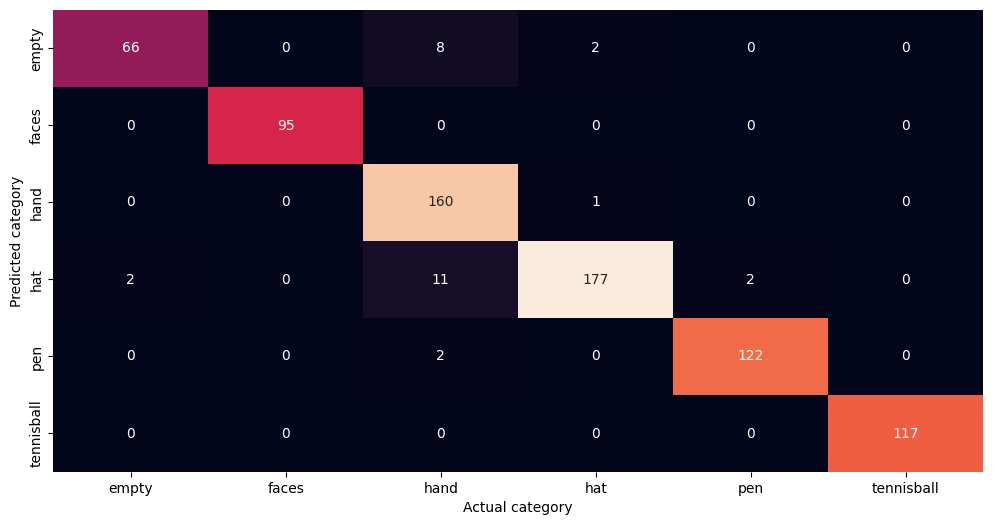

In [17]:
predictions = model1.predict(X_test)
y_pred = np.argmax(predictions, axis=1)  # get the predicted classes
y_actual = np.argmax(y_test, axis=1)  # get the actual classes

# Plot the confusion matrix of our predictions
_fig, ax3 = plt.subplots(figsize=(12, 6))
sns.heatmap(metrics.confusion_matrix(y_actual, y_pred), cbar=False, annot=True, fmt="", ax=ax3)
ax3.set_yticklabels(class_labels)
ax3.set_xticklabels(class_labels)
ax3.set_ylabel("Predicted category")
ax3.set_xlabel("Actual category")
plt.show()

##### Some thoughts on erratic performance towards the end in the validation of the test set  
Overfitting: If your network is overfitting to the training data, its performance on the validation set will likely degrade as training continues. This is because the network will continue to fit the training data better and better, but it will become less and less able to generalize to unseen data.  
High learning rate: If your learning rate is too high, the model's weights will be updated too quickly, which can cause the model's performance to oscillate or diverge. This is because the weights are being updated
in a direction that is not always optimal.  
Noise in the data: If there is noise in the training data, the model's performance on the validation set may be erratic. This is because the model will be fitting to the noise in the training data, which may not be
present in the validation set.  
Insufficient data: If you don't have enough data, the model may not have enough information to learn from, which can cause its performance to be erratic.  
Unstable model architecture: If the model architecture is unstable, the model's performance may be erratic. This can be caused by using an excessively complex model, using an unstable activation function, or using an optimizer with unstable convergence properties.  

To troubleshoot the issue, you may want to try the following:  
Reduce the complexity of the model by using fewer layers or fewer units per layer.  
Use weight regularization or dropout to prevent overfitting.  
Use early stopping to stop the training process before the model starts to overfit.  
Use a smaller learning rate and/or a more stable optimizer.  
Remove noise from the data by preprocessing or denoising the data.  
Add more data to the training set.  
Use a more stable model architecture, such as a simpler model or a different activation function.  

### Model 3: Convolutional neural network

In [18]:
# Make sure to always clear session at the beginning to not just update previous model instances
# Note that this is mostly important for Jupyter Notebooks but good practice either way
K.clear_session()
# Copy X
X_train = X_train_og
X_test = X_test_og
# One-hot encode the target classes / labels
# Needed so that the dimensions match the Dense output layer (at least with softmax activation function)
y_train = LabelBinarizer().fit_transform(y_train_og)
y_test = LabelBinarizer().fit_transform(y_test_og)

#### Define our model:
We know that the input are 224 x 224 x 3 images. For ANN, we have flatten the ndarray.  
The output layer must have as many nodes as there image categories.  
Relu is a popular activation function for hidden layers  
Softmax is a popular activation function for the last, or output, layer  

#### Pipeline the model
From Keras model training API (https://keras.io/api/models/model_training_apis/)  
- Dense: Regular densely-connected neural network layer  
units: neurons/nodes for that layer  
activation: activation function for the nodes  
input_shape: dimensional shape of the input, only needs to be defined for the first layer  
name: some label you can give that layer  
Note that we do not need to add a bias for each layer as they are automatically added in Keras for Dense layers
- Conv2D: A 2D convolutional layer which creates a kernel that is convolved with the layer input to produce a tensor of outputs  
filters: dimensionality of output space (i.e., number of output filters in convolution)  
padding: results in zeros evenly to left/right or up/down of the input  
activation: activation function for the nodes  
kernel_size: specifies height and width of 2D convolution window  
input_shape: dimensional shape of the input, only needs to be defined for the first layer  
- MaxPool2D: Max pooling operation for 2D spatial data. Downsamples the input along its spatial dimensions (h x w) by taking max value over input window (pool_size) for each channel of the input (e.g. pixel)  
- Flatten: Flattens the layer from an multidimensional matrix into a vector  
- Dropout: Randomly sets input units to 0 with rate frequency during training. Helps to prevent overfitting.  

In [19]:
model2 = Sequential(name="CNN_model")
model2.add(
    Conv2D(
        filters=16,
        padding="same",
        activation="relu",
        kernel_size=(3, 3),
        input_shape=np.shape(X_train)[1:],  # rows, cols, color channels
    )
)
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(
    Conv2D(
        filters=32,
        padding="same",
        activation="relu",
        kernel_size=(3, 3),
    )
)
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(
    Conv2D(
        filters=64,
        padding="same",
        activation="relu",
        kernel_size=(3, 3),
    )
)
model2.add(Flatten())
model2.add(Dense(64, activation="relu"))
model2.add(Dropout(0.3))
model2.add(Dense(np.shape(y_train)[1], activation="softmax"))
model2.summary()

Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 200704)            0 

#### Compile the model
loss: loss function to return error estimation  
optimizer: algorithm for loss minimization  
metrics: model performance evaluation metric  


In [20]:
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#### Fit the model
Before fitting, let's define an early stopping rule on loss of the validation set to prevent overfitting
batch_size: number of samples per gradient update  
epochs: number of iterations over the entire data (X and y) to train the model  
validation_data: data on which to evaluate the loss and any model metrics at the end of each epoch (no training on this data!)  

In [21]:
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

In [22]:
model2_history = model2.fit(
    x=X_train,
    y=y_train,
    batch_size=500,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
)

Epoch 1/20
7/7 [==============================] - 5s 208ms/step - loss: 3.9102 - accuracy: 0.2228 - val_loss: 1.7363 - val_accuracy: 0.1621
Epoch 2/20
7/7 [==============================] - 1s 133ms/step - loss: 1.5675 - accuracy: 0.3919 - val_loss: 1.0179 - val_accuracy: 0.6641
Epoch 3/20
7/7 [==============================] - 1s 136ms/step - loss: 0.8748 - accuracy: 0.6778 - val_loss: 0.4498 - val_accuracy: 0.8379
Epoch 4/20
7/7 [==============================] - 1s 133ms/step - loss: 0.4555 - accuracy: 0.8289 - val_loss: 0.3244 - val_accuracy: 0.8588
Epoch 5/20
7/7 [==============================] - 1s 136ms/step - loss: 0.3826 - accuracy: 0.8593 - val_loss: 0.2188 - val_accuracy: 0.9399
Epoch 6/20
7/7 [==============================] - 1s 135ms/step - loss: 0.2478 - accuracy: 0.9241 - val_loss: 0.1521 - val_accuracy: 0.9425
Epoch 7/20
7/7 [==============================] - 1s 132ms/step - loss: 0.1556 - accuracy: 0.9467 - val_loss: 0.1248 - val_accuracy: 0.9477
Epoch 8/20
7/7 [====

#### Evaluate the model
Plot the training history

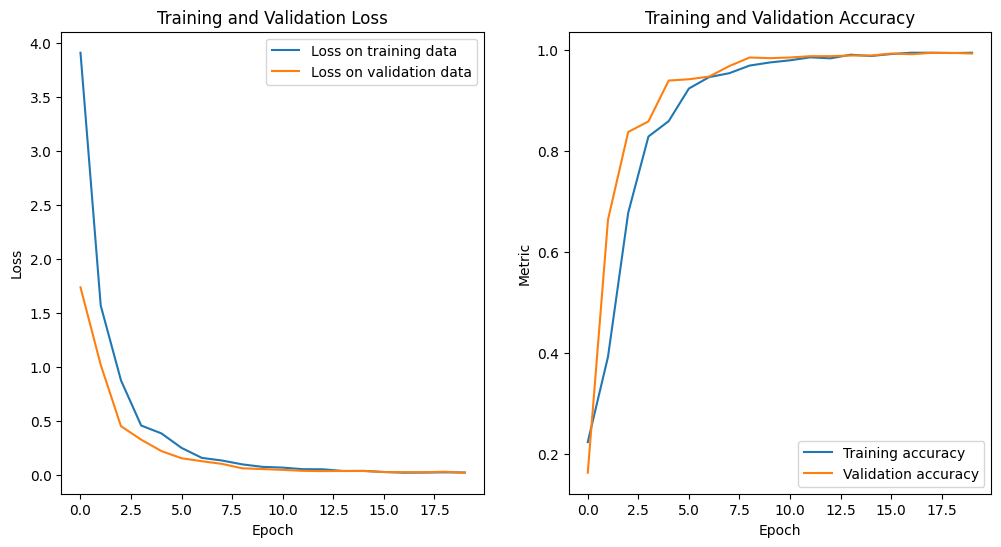

In [23]:
_fig, (ax4, ax5) = plt.subplots(figsize=(12, 6), ncols=2)
ax4.plot(model2_history.history["loss"], label="Loss on training data")
ax4.plot(model2_history.history["val_loss"], label="Loss on validation data")
ax5.plot(model2_history.history["accuracy"], label="Training accuracy")
ax5.plot(model2_history.history["val_accuracy"], label="Validation accuracy")
ax4.set_title("Training and Validation Loss")
ax5.set_title("Training and Validation Accuracy")
ax4.set_xlabel("Epoch")
ax5.set_xlabel("Epoch")
ax4.set_ylabel("Loss")
ax5.set_ylabel("Metric")
ax4.legend()
ax5.legend()

In [24]:
# Return final model performance scores on training and test data
train_loss, train_acc = model2.evaluate(X_train, y_train)
test_loss, test_acc = model2.evaluate(X_test, y_test)
print("Train accuracy:", round(train_acc, 5))
print(
    "Train loss:",
    round(
        train_loss,
    ),
)
print("Test accuracy:", round(test_acc, 5))
print("Test loss:", round(test_loss, 3))

24/24 [==============================] - 0s 6ms/step - loss: 0.0181 - accuracy: 0.9935
Train accuracy: 0.99935
Train loss: 0
Test accuracy: 0.99346
Test loss: 0.018


Accuracy is already good when run on color images. When using blackscale images, accuracy drops indicating that the images do have valuable color information. But also this CNN cannot beat the RF baseline model.

24/24 [==============================] - 0s 4ms/step


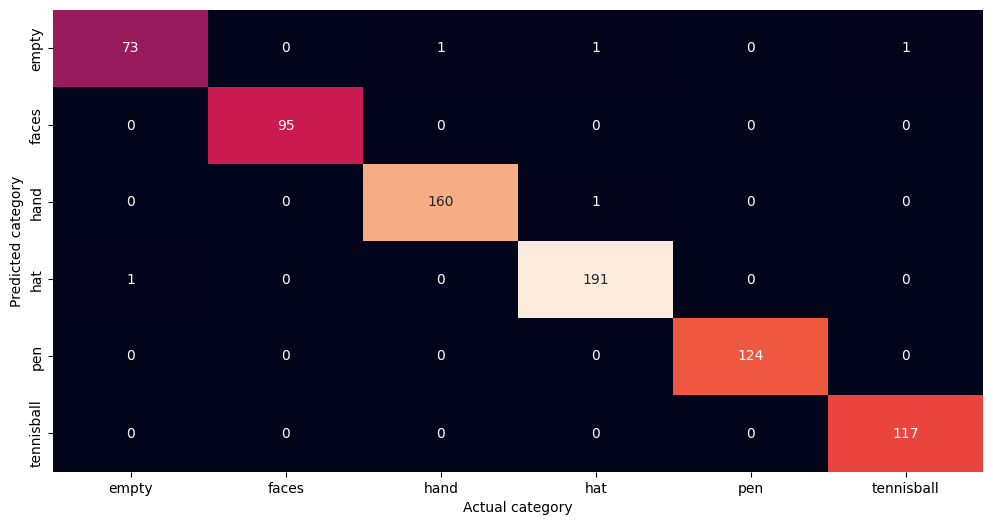

In [25]:
predictions = model2.predict(X_test)
y_pred = np.argmax(predictions, axis=1)  # get the predicted classes
y_actual = np.argmax(y_test, axis=1)  # get the actual classes

# Plot the confusion matrix of our predictions
_fig, ax6 = plt.subplots(figsize=(12, 6))
sns.heatmap(metrics.confusion_matrix(y_actual, y_pred), cbar=False, annot=True, fmt="", ax=ax6)
ax6.set_yticklabels(class_labels)
ax6.set_xticklabels(class_labels)
ax6.set_ylabel("Predicted category")
ax6.set_xlabel("Actual category")
plt.show()

### Model 4: Extend an existing model (here MobileNetV3Large)

In [26]:
# Make sure to always clear session at the beginning to not just update previous model instances
# Note that this is mostly important for Jupyter Notebooks but good practice either way
K.clear_session()
# Copy X
X_train = X_train_og
X_test = X_test_og
# One-hot encode the target classes / labels
# Needed so that the dimensions match the Dense output layer (at least with softmax activation function)
y_train = LabelBinarizer().fit_transform(y_train_og)
y_test = LabelBinarizer().fit_transform(y_test_og)

In [27]:
# We will use MobileNetV3 as our base model since it is pretty lightweight
model_to_extend = MobileNetV3Large(weights="imagenet")
model_to_extend.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                

The input format of MobilenetV3 expects is 224 x 224, so we don't need to preprocess_input.
Let's make an out-of-the-box prediction

In [28]:
predictions = model_to_extend.predict(X_images)
for idx, decoded_prediction in enumerate(decode_predictions(predictions, top=1)):
    for name, desc, score in decoded_prediction:
        if idx % 10 == 0:  # print every 10th item
            print(f"Image: {idx}, Label: {y_labels[idx]}")
            print(f"Top-Prediction: {desc} ({score*100:.2f}%)")

120/120 [==============================] - 3s 21ms/step
Image: 0, Label: empty
Top-Prediction: sleeping_bag (4.72%)
Image: 10, Label: empty
Top-Prediction: studio_couch (7.45%)
Image: 20, Label: empty
Top-Prediction: sleeping_bag (27.81%)
Image: 30, Label: empty
Top-Prediction: abaya (52.34%)
Image: 40, Label: empty
Top-Prediction: loudspeaker (5.15%)
Image: 50, Label: empty
Top-Prediction: abaya (6.63%)
Image: 60, Label: empty
Top-Prediction: television (34.84%)
Image: 70, Label: empty
Top-Prediction: sleeping_bag (38.23%)
Image: 80, Label: empty
Top-Prediction: studio_couch (18.59%)
Image: 90, Label: empty
Top-Prediction: studio_couch (20.68%)
Image: 100, Label: empty
Top-Prediction: sleeping_bag (21.69%)
Image: 110, Label: empty
Top-Prediction: sleeping_bag (38.48%)
Image: 120, Label: empty
Top-Prediction: joystick (14.98%)
Image: 130, Label: empty
Top-Prediction: sleeping_bag (54.59%)
Image: 140, Label: empty
Top-Prediction: sleeping_bag (58.64%)
Image: 150, Label: empty
Top-Predic

This model seems to work well for tennis balls, okay-ish for empty (identified as the bed/sleeping bag in the background), sometimes for hats, not at all for pens, hand and faces

In [29]:
# We now connect a new layer for our six objects to the second-to-last layer.
new_output_layer = Dense(6, activation="softmax", name="NewOutputLayer")
new_output_layer = new_output_layer(
    model_to_extend.layers[-2].output
)  # output second-to-last layer
model_to_extend_input = model_to_extend.input
# Create a model with the new layer
model_extended = Model(inputs=model_to_extend_input, outputs=new_output_layer)
model_extended.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                           

In [30]:
# Now freeze the pre-trained layers
for layer in model_extended.layers[:-1]:
    layer.trainable = False

#### Recompile the new old model
loss: loss function to return error estimation  
optimizer: algorithm for loss minimization  
metrics: model performance evaluation metric  


In [31]:
model_extended.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#### Fit the model
Before fitting, let's define an early stopping rule on loss of the validation set to prevent overfitting
batch_size: number of samples per gradient update
epochs: number of iterations over the entire data (X and y) to train the model
validation_data: data on which to evaluate the loss and any model metrics at the end of each epoch (no training on this data!)


In [32]:
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

In [33]:
model3_history = model_extended.fit(
    x=X_train,
    y=y_train,
    batch_size=500,
    epochs=35,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
)

Epoch 1/35
7/7 [==============================] - 6s 390ms/step - loss: 2.5796 - accuracy: 0.1838 - val_loss: 1.8539 - val_accuracy: 0.2510
Epoch 2/35
7/7 [==============================] - 1s 210ms/step - loss: 2.0531 - accuracy: 0.1832 - val_loss: 1.9408 - val_accuracy: 0.2575
Epoch 3/35
7/7 [==============================] - 1s 215ms/step - loss: 1.9622 - accuracy: 0.2538 - val_loss: 1.7588 - val_accuracy: 0.2144
Epoch 4/35
7/7 [==============================] - 1s 200ms/step - loss: 1.8169 - accuracy: 0.2071 - val_loss: 1.7854 - val_accuracy: 0.1477
Epoch 5/35
7/7 [==============================] - 1s 209ms/step - loss: 1.8214 - accuracy: 0.2345 - val_loss: 1.7214 - val_accuracy: 0.2641
Epoch 6/35
7/7 [==============================] - 1s 214ms/step - loss: 1.7987 - accuracy: 0.2270 - val_loss: 1.7141 - val_accuracy: 0.3229
Epoch 7/35
7/7 [==============================] - 1s 210ms/step - loss: 1.7797 - accuracy: 0.2610 - val_loss: 1.7065 - val_accuracy: 0.2510
Epoch 8/35
7/7 [====

#### Evaluate the model
Plot the training history


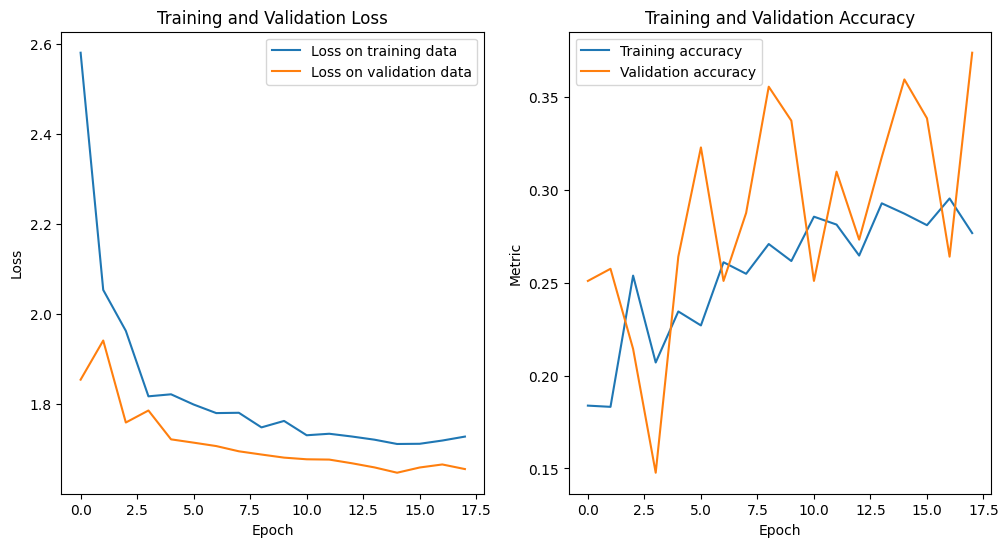

In [34]:
_fig, (ax7, ax8) = plt.subplots(figsize=(12, 6), ncols=2)
ax7.plot(model3_history.history["loss"], label="Loss on training data")
ax7.plot(model3_history.history["val_loss"], label="Loss on validation data")
ax8.plot(model3_history.history["accuracy"], label="Training accuracy")
ax8.plot(model3_history.history["val_accuracy"], label="Validation accuracy")
ax7.set_title("Training and Validation Loss")
ax8.set_title("Training and Validation Accuracy")
ax7.set_xlabel("Epoch")
ax8.set_xlabel("Epoch")
ax7.set_ylabel("Loss")
ax8.set_ylabel("Metric")
ax7.legend()
ax8.legend()
plt.show()

This model doesn't really perform well. There are several ways to go about improving it but this is all for this exercise.